In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install sincnet_tensorflow

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv1D, LeakyReLU, BatchNormalization, Flatten, MaxPooling1D, Input
from sincnet_tensorflow import SincConv1D, LayerNorm
from sklearn.model_selection import train_test_split
import random
import pandas as pd
import librosa


In [4]:
# Cambia este path al lugar donde tienes tu archivo de texto y los audios
data_path = '/content/drive/.shortcut-targets-by-id/1MDEuAKtcvr_saVdZcC0ImDUZsJdQhf2U/TC5035 - Proyecto Integrador/Codigos de Prueba/Datasets/frase/Total/Enfermos/'
patologias_file = 'lista_pathological_info.txt'

# Crear un DataFrame vacío
columns = ['AudioID', 'AgeRange', 'Gender', 'Pathology', 'AudioFilePath']
df_patologias = pd.DataFrame(columns=columns)

# Lista de patologías de interés
patologias_interes = ['Dysphonie', 'Laryngitis', 'Rekurrensparese', 'Sano']

# Leer el archivo de patologías y llenar el DataFrame
with open(os.path.join(data_path, patologias_file), 'r') as file:
    for line in file:
        parts = line.strip().split(' ')
        audio_id = parts[0]
        age_range = parts[1]
        gender = parts[2]
        # Suponiendo que la patología está al final y puede tener múltiples elementos separados por comas
        pathology = ' '.join(parts[3:])
        audio_file_path = os.path.join(data_path, f"{audio_id}-phrase.wav")

        # Verificar y añadir cada patología de interés si está presente
        for pat in patologias_interes:
            if pat in pathology:
                # Crear un DataFrame para la nueva fila
                new_row_df = pd.DataFrame([{'AudioID': audio_id, 'AgeRange': age_range, 'Gender': gender, 'Pathology': pat, 'AudioFilePath': audio_file_path}])

                # Usar pd.concat para concatenar el nuevo DataFrame con el existente
                df_patologias = pd.concat([df_patologias, new_row_df], ignore_index=True)

print(df_patologias.head())


  AudioID AgeRange  Gender        Pathology  \
0    1037    49-51  Female        Dysphonie   
1    1040    60-62  Female  Rekurrensparese   
2    1042    46-49    Male        Dysphonie   
3    1043    41-45    Male        Dysphonie   
4    1044    31-35  Female        Dysphonie   

                                       AudioFilePath  
0  /content/drive/.shortcut-targets-by-id/1MDEuAK...  
1  /content/drive/.shortcut-targets-by-id/1MDEuAK...  
2  /content/drive/.shortcut-targets-by-id/1MDEuAK...  
3  /content/drive/.shortcut-targets-by-id/1MDEuAK...  
4  /content/drive/.shortcut-targets-by-id/1MDEuAK...  


In [5]:
df_patologias

,AudioID,AgeRange,Gender,Pathology,AudioFilePath
0,1037,49-51,Female,Dysphonie,/content/drive/.shortcut-targets-by-id/1MDEuAK...
1,1040,60-62,Female,Rekurrensparese,/content/drive/.shortcut-targets-by-id/1MDEuAK...
2,1042,46-49,Male,Dysphonie,/content/drive/.shortcut-targets-by-id/1MDEuAK...
3,1043,41-45,Male,Dysphonie,/content/drive/.shortcut-targets-by-id/1MDEuAK...
4,1044,31-35,Female,Dysphonie,/content/drive/.shortcut-targets-by-id/1MDEuAK...
...,...,...,...,...,...
899,929,52-54,Female,Rekurrensparese,/content/drive/.shortcut-targets-by-id/1MDEuAK...
900,930,19-30,Male,Laryngitis,/content/drive/.shortcut-targets-by-id/1MDEuAK...
901,931,52-54,Female,Laryngitis,/content/drive/.shortcut-targets-by-id/1MDEuAK...
902,934,26-30,Female,Dysphonie,/content/drive/.shortcut-targets-by-id/1MDEuAK...


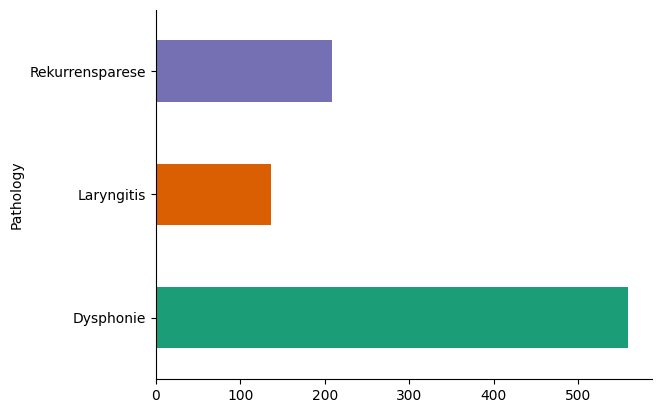

In [6]:
# @title Pathology

from matplotlib import pyplot as plt
import seaborn as sns
df_patologias.groupby('Pathology').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [7]:
patologias_path = data_path + 'lista_pathological_info.txt'

# Diccionario para mapear el nombre del archivo de audio a sus detalles
audio_details = {}

with open(patologias_path, 'r') as file:
    for line in file:
        # Dividir la línea por espacios
        parts = line.strip().split(' ')
        audio_id = parts[0]
        gender = parts[2]
        pathologies = ' '.join(parts[3:]).split(' laryngitis')
        if len(pathologies) > 1:
            # Si tiene más de una patología, agregamos 'laryngitis' de nuevo al principio de cada patología adicional
            pathologies = [pathologies[0]] + ['laryngitis' + pathology for pathology in pathologies[1:]]
        # Nombre del archivo de audio
        audio_filename = f"{audio_id}-phrase.wav"
        # Guardar los detalles en el diccionario
        audio_details[audio_filename] = {'gender': gender, 'pathologies': pathologies}

# Ejemplo para verificar algunos datos cargados
print(list(audio_details.items())[:5])


[('101-phrase.wav', {'gender': 'Female', 'pathologies': ['Bulbarparalyse']}), ('1037-phrase.wav', {'gender': 'Female', 'pathologies': ['Hyperfunktionelle_Dysphonie']}), ('1038-phrase.wav', {'gender': 'Female', 'pathologies': ['Gesangsstimme']}), ('1039-phrase.wav', {'gender': 'Male', 'pathologies': ['Vox_senilis']}), ('1040-phrase.wav', {'gender': 'Female', 'pathologies': ['Rekurrensparese']})]


In [8]:
import librosa
import numpy as np

def load_audio_features(file_path):
    audio, sample_rate = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
    mfccs_processed = np.mean(mfccs.T, axis=0)
    return mfccs_processed

# Supongamos que quieres cargar las características de todos los archivos de audio y sus etiquetas
features = []
labels = []

for audio_filename, details in  audio_details.items():
    file_path = data_path + audio_filename
    try:
        # Cargar características del audio
        audio_features = load_audio_features(file_path)
        features.append(audio_features)
        # Asumiendo que solo quieres la primera patología como etiqueta por simplicidad
        labels.append(details['pathologies'][0])
    except FileNotFoundError:
        print(f"Archivo no encontrado: {file_path}")
        continue

# Ahora tienes 'features' y 'labels' listos para ser utilizados en entrenamiento de modelos


In [9]:


# Función para cargar las características de un archivo de audio
def load_audio_features(file_path):
    audio, sample_rate = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
    mfccs_processed = np.mean(mfccs.T, axis=0)
    return mfccs_processed

# Cargar características del primer archivo de audio en el DataFrame
first_audio_path = df_patologias.loc[0, 'AudioFilePath']
features = load_audio_features(first_audio_path)
print(features)

[-3.88286469e+02  1.16648483e+02  1.28064003e+01  5.17880516e+01
  1.48881989e+01  1.12274008e+01  8.38192463e-01 -1.24843752e+00
  1.89026225e+00 -1.74732900e+00 -4.25775528e+00 -8.77251148e+00
  1.24008745e-01]


In [10]:
import librosa
def cargar_audio(archivo_path):
    # Carga el archivo de audio usando librosa
    audio, _ = librosa.load(archivo_path, sr=50000)  # Asume una frecuencia de muestreo de 16000 Hz

    # Asegúrate de que los datos estén en el formato correcto (8000 puntos de datos)
    if len(audio) <70000:
        # Si el audio es más corto, rellena con ceros
        audio = np.pad(audio, (0, 70000 - len(audio)))
    elif len(audio) > 70000:
        # Si el audio es más largo, truncalo
        audio = audio[:70000]

    # Formatea los datos para que tengan la forma (8000, 1)
    audio = audio.reshape((70000, 1))

    return audio

In [14]:
# la ubicación de tus audios sanos
healthy_data_path = '/content/drive/.shortcut-targets-by-id/1MDEuAKtcvr_saVdZcC0ImDUZsJdQhf2U/TC5035 - Proyecto Integrador/Codigos de Prueba/Datasets/frase/Total/Sanos'

# Obtener la lista de archivos de audio en la carpeta de audios sanos
healthy_audio_files = [f for f in os.listdir(healthy_data_path) if f.endswith('.wav')]

# Listas para almacenar características y etiquetas
features_list = []
labels_list = []

for index, row in df_patologias.iterrows():
    audio_file_path = row['AudioFilePath']
    pathology = row['Pathology']

    try:
        # Cargar las características del audio usando la función cargar_audio
        features = cargar_audio(audio_file_path)
        # Añadir las características y la etiqueta a las listas
        features_list.append(features)
        labels_list.append(pathology)
    except Exception as e:
        print(f"Error cargando {audio_file_path}: {e}")
for file_name in healthy_audio_files:
    audio_file_path = os.path.join(healthy_data_path, file_name)

    try:
        # Cargar las características del audio utilizando la función cargar_audio
        features = cargar_audio(audio_file_path)  # Usar cargar_audio en lugar de load_audio_features
        # Añadir las características a la lista
        features_list.append(features)
        # Añadir la etiqueta "Sano" a la lista de etiquetas
        labels_list.append("Sano")
    except Exception as e:
        print(f"Error cargando {audio_file_path}: {e}")
# Convertir las listas en arrays de numpy para su uso en modelos de ML
features_array = np.array(features_list)
labels_array = np.array(labels_list)

print(f"Características cargadas: {features_array.shape}")
print(f"Etiquetas cargadas: {labels_array.shape}")

Características cargadas: (1538, 70000, 1)
Etiquetas cargadas: (1538,)


In [16]:
X = features_array
y = labels_array

In [17]:
import pandas as pd

# Asumiendo que 'y' es una lista o array de tus etiquetas (puede ser numérico o de texto)
# Ejemplo: y = ['Dysphonie', 'Laryngitis', 'Paralysis', 'sano', 'Dysphonie', ...]

y_series = pd.Series(y)

# Contar ocurrencias
label_counts = y_series.value_counts()

print("Conteo de etiquetas por clase:")
print(label_counts)

Conteo de etiquetas por clase:
Sano               634
Dysphonie          559
Rekurrensparese    209
Laryngitis         136
dtype: int64


In [18]:
from sklearn.preprocessing import LabelEncoder

# Codificar las etiquetas
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Opcional: Convertir las etiquetas numéricas a one-hot encoding
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
y_onehot = onehot_encoder.fit_transform(y_encoded.reshape(len(y_encoded), 1))


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [19]:
import numpy as np

# Suponiendo que y_encoded contiene tus etiquetas codificadas
unique_classes = np.unique(y_encoded)
num_classes = len(unique_classes)
print(f"Número de clases únicas: {num_classes}")

Número de clases únicas: 4


In [20]:
# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:

# Convertir las etiquetas a una Serie de pandas
labels_series = pd.Series(y_encoded)

# Contar el número de clases únicas
unique_classes = labels_series.unique()
num_classes = len(unique_classes)
print(f"Número de clases únicas: {num_classes}")

Número de clases únicas: 4


In [22]:

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, LeakyReLU, MaxPooling1D, LayerNormalization

# Número de clases, ajusta este valor según tu dataset
out_dim = 4  # Asegúrate de que esto coincida con el número real de clases que tienes

inputs = Input((70000, 1))
x = SincConv1D(N_filt=64, Filt_dim=129, fs=50000, stride=16, padding="SAME")(inputs)
x = LayerNormalization()(x)

x = LeakyReLU(alpha=0.2)(x)
x = MaxPooling1D(pool_size=2)(x)

# Aquí puedes añadir más capas a tu modelo según sea necesario

x = Flatten()(x)
x = Dense(256)(x)
x = BatchNormalization(momentum=0.05, epsilon=1e-5)(x)
x = LeakyReLU(alpha=0.2)(x)

x = Dense(256)(x)
x = BatchNormalization(momentum=0.05, epsilon=1e-5)(x)
x = LeakyReLU(alpha=0.2)(x)

# Capa de salida para clasificación multiclase
outputs = Dense(out_dim, activation='softmax')(x)

# Definición del modelo
model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Resumen del modelo
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 70000, 1)]        0         
                                                                 
 sinc_conv1d (SincConv1D)    (None, 4375, 64)          128       
                                                                 
 layer_normalization (Layer  (None, 4375, 64)          128       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4375, 64)          0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 2187, 64)          0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 139968)            0     

In [23]:
# Suponiendo que y_train contiene etiquetas textuales
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Ahora y_train_encoded contiene valores numéricos en lugar de cadenas
# Continúa con el entrenamiento utilizando y_train_encoded
model.fit(X_train, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2, verbose=1)


31/31 [==============================] - 66s 2s/step - loss: 1.4781 - accuracy: 0.4472 - val_loss: 1.1790 - val_accuracy: 0.5528
Epoch 2/10
31/31 [==============================] - 60s 2s/step - loss: 0.4372 - accuracy: 0.8852 - val_loss: 1.2813 - val_accuracy: 0.5203
Epoch 3/10
31/31 [==============================] - 58s 2s/step - loss: 0.1231 - accuracy: 0.9848 - val_loss: 1.6461 - val_accuracy: 0.5325
Epoch 4/10
31/31 [==============================] - 60s 2s/step - loss: 0.0519 - accuracy: 0.9909 - val_loss: 1.6826 - val_accuracy: 0.4715
Epoch 5/10
31/31 [==============================] - 61s 2s/step - loss: 0.0338 - accuracy: 0.9939 - val_loss: 1.8888 - val_accuracy: 0.4878
Epoch 6/10
31/31 [==============================] - 60s 2s/step - loss: 0.0284 - accuracy: 0.9959 - val_loss: 1.6691 - val_accuracy: 0.5041
Epoch 7/10
31/31 [==============================] - 70s 2s/step - loss: 0.0205 - accuracy: 0.9939 - val_loss: 1.8394 - val_accuracy: 0.5081
Epoch 8/10
31/31 [=============

In [24]:
X_test.shape

(308, 70000, 1)

In [25]:
y_test.shape

(308,)

In [26]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


# Primero, convierte las etiquetas categóricas a numéricas
label_encoder = LabelEncoder()
y_numerical = label_encoder.fit_transform(y)

# Ahora, convierte las etiquetas numéricas a one-hot encoding
y_one_hot = to_categorical(y_numerical)

# Continúa con la división de los datos o cualquier otro paso siguiente



In [27]:
y_numerical[5]

1

In [28]:
y[5]

'Laryngitis'

In [29]:
from sklearn.model_selection import train_test_split

# Suponiendo que 'X' contiene tus datos de características
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.3, random_state=42)

In [30]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Hacer predicciones
predictions = model.predict(X_test)

# Convertir predicciones y etiquetas verdaderas de one-hot a formato numérico
y_pred = np.argmax(predictions, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Calcular la matriz de confusión y otras métricas
cm = confusion_matrix(y_test_labels, y_pred)
print("Matriz de Confusión:")
print(cm)

report = classification_report(y_test_labels, y_pred, target_names=['Dysphonie', 'Laryngitis', 'Rekurrensparese', 'Sano'])
print("\nMétricas de Clasificación:")
print(report)


15/15 [==============================] - 8s 475ms/step
Matriz de Confusión:
[[ 76   5  11  58]
 [ 16  16   4  10]
 [ 15   0  33   8]
 [ 20   1   5 184]]

Métricas de Clasificación:
                 precision    recall  f1-score   support

      Dysphonie       0.60      0.51      0.55       150
     Laryngitis       0.73      0.35      0.47        46
Rekurrensparese       0.62      0.59      0.61        56
           Sano       0.71      0.88      0.78       210

       accuracy                           0.67       462
      macro avg       0.66      0.58      0.60       462
   weighted avg       0.66      0.67      0.65       462

